# Environment: Python 3.5

In [1]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
from sklearn.preprocessing import normalize

import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
from ast import literal_eval

# For Python2 this have to be done
# from __future__ import division


import gzip
import string
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
ITEM_ID = 'business_id'
USER_ID = 'user_id'
RATING = 'rating'
BINARY_RATING = 'Binary'
REVIEW_TEXT = 'review_text'
TIMESTAMP = 'review_date'
# TIMESTAMP = 'timestamp'
DATA_PATH = '../../data/yelp/'
DATA_NAME = 'toronto_reviews.csv'

In [107]:
# Load Original Data

dataset_name = 'yelp'

df = pd.read_csv('../../data/'+ dataset_name +'/toronto_reviews.csv')
# df_train = pd.read_csv('../../data/'+ dataset_name +'/Train.csv')
# df_valid = pd.read_csv('../../data/'+ dataset_name +'/Valid.csv')
# df_test = pd.read_csv('../../data/'+ dataset_name +'/Test.csv')
# key_phrase = pd.read_csv('../data/'+ dataset_name +'/KeyPhrases.csv')

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,...,review_language,review_text,ufc,user_id,user_loc,vote_count,Updated,Year,Month,Day
0,0,0,bSQGCheX1BwvL67Az1OJlA,90,False,[],[],False,231.0,5.0,...,en,I had a good experience at this store. I was g...,"[10, 1, 10]",q41qqkChL9fRxF43cnkgbw,"Houston, TX",11.0,False,2018,5,9
1,1,1,bSQGCheX1BwvL67Az1OJlA,0,False,[],[],False,9.0,1.0,...,en,I reaaaaaally wish I had read all the stories ...,"[0, 0, 0]",tNT5I9-QcljS-7w_doXCXQ,"Toronto, Canada",0.0,False,2018,6,3
2,2,2,bSQGCheX1BwvL67Az1OJlA,52,False,"[""Photo of Sleep Country - Toronto, ON, Canada...",['https://s3-media1.fl.yelpcdn.com/bphoto/E_gL...,False,27.0,1.0,...,en,Everything was fine until the delivery. I wait...,"[3, 1, 2]",9q1Do6TVM27RNHUQAQxPRg,"Toronto, Canada",3.0,False,2016,30,7
3,3,3,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,...,en,"Thought I had bed bugs, but it turned out to b...","[0, 0, 0]",cr-4gAf1_seYWLoO59Lp4w,"Old Toronto, Toronto, Canada",0.0,False,2018,16,12
4,4,4,Z7JV11GXw_RsGr8Ik_Hsag,0,False,[],[],False,NaN,5.0,...,en,"When we called, Mr. Akram was willing to come ...","[1, 0, 0]",CQkTIyhNczRlRI4kIdAzSw,"Toronto, Canada",1.0,False,2014,6,8


### Sushi on bloor

In [31]:
np.where(df.business_id == '6n_MDeYxU1ihB38be9TkVA')

(array([], dtype=int64),)

### Spicy Mafia

In [59]:
np.where(df.business_id == 'l_uAw0K2lkOsyVJATcnwsA')

(array([539154, 539155, 539156, 539157, 539158, 539159, 539160, 539161,
        539162, 539163, 539164, 539165], dtype=int64),)

In [39]:
df.loc[539160]

business_id                                   l_uAw0K2lkOsyVJATcnwsA
friend_count                                                       0
ghost                                                          False
img_dsc                                                           []
img_url                                                           []
nr                                                             False
photo_count                                                       21
rating                                                             3
review_count                                                      24
review_date                                      ['1', '23', '2018']
review_id                                     Mu-yLnxsuj2JjEZBXt5A9A
review_language                                                   en
review_text        This place is ok. I honestly feel like I could...
ufc                                                        [0, 0, 0]
user_id                           

In [29]:
df['review_text'][539159]

"If you like hotpot but don't have a lot of time or the capacity to go all out on all-you-can-stuff deals, this is the place for you. \xa0It's your own personalized hotpot bowl with all the fixings you'd want. \xa0They have option for fresh meat (chicken or angus beef), you just have to ask at the counter. \xa0The house special broth varies from mild to fires of Mount Doom spicy (seriously- the bowl was flaming red with hot chilli bits floating on top). Oh, the best part- you can pack it to go."

# Filter

In [48]:
df[ITEM_ID].nunique()

32022

In [49]:
df[USER_ID].nunique()

128419

In [91]:
def filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
                   user_review_threshold=10, item_review_threshold=10, 
                   num_user=None, num_item=None, user_ratio=0.25, item_ratio=0.2):
    # Binarize rating
    df[BINARY_RATING] = (df[RATING] > threshold)*1

    # Filter dataset only based on positive ratings
    df = df[df[BINARY_RATING] == 1]
    
    print("The total number of users is {}".format(df[USER_ID].nunique()))
    print("The total number of items is {} \n".format(df[ITEM_ID].nunique()))
    

    values = df[ITEM_ID].value_counts().keys().tolist()
    counts = df[ITEM_ID].value_counts().tolist()
    item_df = pd.DataFrame.from_dict({ITEM_ID: values, "count": counts})
    
    values = df[USER_ID].value_counts().keys().tolist()
    counts = df[USER_ID].value_counts().tolist()
    user_df = pd.DataFrame.from_dict({USER_ID: values, "count": counts})
    
    if popularity:
        print("Filter dataset by popularity. \n")
        
        if filter_by_review_count:
            print("Filter dataset by review count. \n")
            
            filtered_item_df = item_df[item_df["count"] >= item_review_threshold]
            filtered_item_id = filtered_item_df[ITEM_ID].values
            
            filtered_user_df = user_df[user_df["count"] >= user_review_threshold]
            filtered_user_id = filtered_user_df[USER_ID].values
            
        else:
            print("Filter dataset by user and item number. \n")
            filtered_item_id = item_df[ITEM_ID].unique()[:num_item]
            filtered_user_id = user_df[USER_ID].unique()[:num_user]
            
    else:
        print("Filter dataset by sampling. \n")
        np.random.seed(8292)
        
        filtered_item_id = np.take(item_df[ITEM_ID].unique(), 
                                   indices=np.random.choice(len(item_df), int(item_ratio*len(item_df))))
        filtered_user_id = np.take(user_df[USER_ID].unique(), 
                                   indices=np.random.choice(len(user_df), int(user_ratio*len(user_df))))
        
    df = df.loc[(df[USER_ID].isin(filtered_user_id)) & (df[ITEM_ID].isin(filtered_item_id))]
#     df = df.loc[(df[ITEM_ID].isin(filtered_item_id))]
    print("Number of User: {}".format(df[USER_ID].nunique()))
    print("Number of Item: {}".format(df[ITEM_ID].nunique()))

    return df

# Filter the dataset by popularity then by number of users and items

In [117]:
filtered_df = filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
                             user_review_threshold=5, item_review_threshold=5, 
                             num_user=15000, num_item=1000, user_ratio=None, item_ratio=None)

The total number of users is 90758
The total number of items is 27896 

Filter dataset by popularity. 

Filter dataset by review count. 

Number of User: 13912
Number of Item: 11915


In [118]:
np.where(filtered_df.business_id == 'l_uAw0K2lkOsyVJATcnwsA')

(array([147553, 147554, 147555, 147556], dtype=int64),)

# Analyze filtered dataset

In [120]:
filtered_df = filtered_df.reset_index(drop = True)

In [121]:
filtered_df.head()

,Unnamed: 0,Unnamed: 0.1,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,...,review_text,ufc,user_id,user_loc,vote_count,Updated,Year,Month,Day,Binary
0,6,6,Xo1LNzhnwE-ilqsM3ybs9Q,105,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tu7j...,False,325.0,4.0,...,I ordered the lemon mango slush and the lemon ...,"[1, 1, 1]",zsJFjhBQEFQ6gJ7BsNM_Ug,"Toronto, Canada",1.0,False,2016,23,8,1
1,8,8,Xo1LNzhnwE-ilqsM3ybs9Q,239,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tS6Y...,False,78.0,5.0,...,{Grapefruit & Yakult Green Tea with Aloe Jelly...,"[0, 0, 0]",C91it8b3odRg0503asUaJA,"Markham, Canada",0.0,False,2016,6,11,1
2,9,9,Xo1LNzhnwE-ilqsM3ybs9Q,10,False,"['Photo of Happy Lemon - Markham, ON, Canada',...",['https://s3-media3.fl.yelpcdn.com/bphoto/rfB0...,False,504.0,4.0,...,Saw this newly opened bubble tea shop and want...,"[0, 0, 0]",dAB-v4B-5_8QgTcoVSnZOw,"Vaughan, Canada",0.0,False,2016,25,9,1
3,10,10,Xo1LNzhnwE-ilqsM3ybs9Q,121,False,[],[],False,39.0,5.0,...,Walked by pmall and the poster of the salty ch...,"[2, 2, 1]",UxwiJpYSqOZJQzUMF6Xl6A,"Toronto, Canada",3.0,False,2016,6,9,1
4,14,14,Xo1LNzhnwE-ilqsM3ybs9Q,216,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/T5NT...,False,10.0,4.0,...,Nice place. They have this salted cheese green...,"[1, 1, 1]",OXuToHJF6vYo3dxS7VYfWA,"Toronto, Canada",1.0,False,2016,21,9,1


In [122]:
values = filtered_df[USER_ID].value_counts().keys().tolist()
counts = filtered_df[USER_ID].value_counts().tolist()
user_df = pd.DataFrame.from_dict({USER_ID: values, "count": counts})

values = filtered_df[ITEM_ID].value_counts().keys().tolist()
counts = filtered_df[ITEM_ID].value_counts().tolist()
item_df = pd.DataFrame.from_dict({ITEM_ID: values, "count": counts})

In [123]:
item_df.tail()

,business_id,count
11910,FACbuKfug1Ipy4R2lAHZfw,1
11911,M22Dy0HX9ZTpBAjTaPgAQQ,1
11912,KHn7gcZrihI-7gHYgOxEQg,1
11913,5qC1hMEnYok0BIzV9EqdVA,1
11914,01g3uA1reCJUt5HzXeJlsg,1


In [124]:
item_df["count"].mean()

17.11900965169954

In [125]:
user_df[user_df["count"] >= 20]

,count,user_id
0,714,CxDOIDnH8gp9KXzpBHJYXw
1,485,Q9mA60HnY87C1TW5kjAZ6Q
2,346,WeVkkF5L39888IPPlRhNpg
3,315,ic-tyi1jElL_umxZVh8KNA
4,310,FREeRQtjdJU83AFtdETBBw
5,283,JrXC_MDp38BWwLn2SFdNsA
6,265,0BBUmH7Krcax1RZgbH4fSA
7,254,JLv2Dmfj73-I0d9N41tz1A
8,252,j6wLUT0ZXi-x0otelYIFpA
9,243,Nq6e5N8bjgD9B46O4va_zA


In [126]:
users = user_df[user_df["count"] >= 20][USER_ID].values

In [127]:
pos_df = filtered_df.loc[filtered_df[USER_ID].isin(users)].reset_index(drop=True)
# pos_df

# Export the filtered dataset

# pos_df.to_csv(DATA_PATH+DATA_NAME+".csv", header=False)

In [128]:
items = pos_df[ITEM_ID].values

# Get the Final DF with reviews

In [129]:
cur_df = df.loc[(df[USER_ID].isin(users)) & (df[ITEM_ID].isin(items))].reset_index(drop=True)
# cur_df

In [130]:
cur_df[USER_ID].nunique()

2473

In [131]:
cur_df[ITEM_ID].nunique()

10282

# Split dataset 

In [214]:
# No split is done for now

# Pre-process Reviews

In [133]:
def preprocess(text):
#     text = text.replace('.',' ').replace('/',' ').replace('quot;', ' ').replace('amp;', '').replace('-', ' ')
    
    text = text.replace('.',' ').replace('/t',' ').replace('\t',' ').replace('/',' ').replace('-',' ')
    
    # Tokenize
    text = nltk.word_tokenize(text)
    
    # Lowercase
    text = [w.lower() for w in text]

    # Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]

    # Remove tokens that are not alphabetic
    text = [w for w in text if w.isalpha()]

    # Remove Stopwords
    # Get english stopwords
    en_stopwords = set(stopwords.words('english'))
    en_stopwords.remove('off')
    text = [w for w in text if w not in en_stopwords]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]

    text = " " + " ".join(str(x) for x in text) + " "

    text = text.replace('whitish', 'white')
    text = text.replace('bisquity', ' biscuit ')
    text = text.replace('carmel', ' caramel ')
    text = text.replace('flower', ' floral ')
    text = text.replace('piny', ' pine ')
    text = text.replace('off white', 'offwhite')
    text = text.replace('goden', 'gold')
    text = text.replace('yello', 'yellow')
    text = text.replace('reddish', ' red ') 
    

    # Reset to token
    text = nltk.word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]
    text = [w for w in text if w.isalpha()]
#     en_stopwords = set(stopwords.words('english'))
    text = [w for w in text if w not in en_stopwords]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    
    return text
    
cur_df["review"] = cur_df[REVIEW_TEXT].apply(preprocess)
cur_df["conca_review"] = cur_df["review"].apply(lambda x: " " + " ".join(str(x) for x in x) + " ")

cur_df.to_pickle('../../data/yelp/cur_df.pkl')

# Index words since no further changes will be made on the words

In [134]:
tokenizer = Tokenizer()
token_list = cur_df["review"].tolist()
tokenizer.fit_on_texts(token_list)

In [135]:
df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [ ]:
df_word_index

In [ ]:
df_word_index

In [136]:
token_flatten_list = [item for sublist in token_list for item in sublist]

In [137]:
total_token = len(token_flatten_list)
total_token

13248601

In [138]:
from nltk.probability import FreqDist

fdist1 = FreqDist(token_flatten_list)

In [ ]:
# fdist1.most_common(250)

In [139]:
# Keyphrases are chosen mannually from top-1000 
fdist1.most_common(250)

[('nt', 173709),
 ('place', 139275),
 ('good', 129845),
 ('food', 120863),
 ('like', 97885),
 ('one', 87408),
 ('time', 86121),
 ('really', 77363),
 ('get', 76907),
 ('would', 76558),
 ('great', 73217),
 ('also', 68551),
 ('service', 68340),
 ('go', 58284),
 ('back', 56937),
 ('restaurant', 56285),
 ('come', 54176),
 ('chicken', 52148),
 ('came', 49140),
 ('ordered', 47387),
 ('dish', 47130),
 ('well', 46924),
 ('nice', 46118),
 ('got', 45811),
 ('try', 44341),
 ('order', 43970),
 ('menu', 41857),
 ('pretty', 41615),
 ('definitely', 41254),
 ('price', 40364),
 ('table', 40104),
 ('bit', 39342),
 ('much', 37906),
 ('u', 37610),
 ('even', 37242),
 ('sauce', 36946),
 ('little', 36558),
 ('friend', 36336),
 ('make', 36063),
 ('lot', 35676),
 ('delicious', 35008),
 ('people', 33972),
 ('drink', 33730),
 ('love', 33309),
 ('could', 33300),
 ('taste', 31787),
 ('thing', 31649),
 ('small', 31310),
 ('first', 31244),
 ('always', 30853),
 ('best', 30734),
 ('rice', 30341),
 ('quite', 30321),
 ('

In [213]:
category_key = ['chinese', 'fast', 'thai', 'bar', 'fry', 'fried', 'dessert', 'dinner', 'lunch', 'soup', 
                'mexico', 'italian','mexican','vietnamese','buffet','takeout','casual','pub','bakery','indian','classic',
               'modern','french','asian','birthday', 'vegetarian', 'downtown', 'bbq','japanese','breakfast','seafood',
               'brunch'] 

food_key = ['taco', 'curry', 'potato', 'crispy', 'shrimp', 'bread', 'chocolate', 'ramen', 'pizza', 'beer', 'sandwich', 'cake',
            'sushi', 'egg', 'fish', 'coffee', 'burger', 'cheese', 'salad', 'pork', 'beef', 'tea', 'noodle',
           'meat', 'chicken', 'dim sum', 'cocktail', 'ice cream','squid','tempura','tapioca','donut','olive',
            'espresso','octopus','croissant','banana','cookie','honey','cone','scallop','congee',
           'skewer','miso','lettuce','pop','strawberry','apple','avocado','juice','booth','calamari','kimchi','patty',
           'sesame','tart','four','crepe','tuna','wrap','lemon','vegan','coconut','corn','poutine','toast','belly','bubble',
           'oyster','cocktail', 'cheesecake', 'fruit', 'sausage','latte','matcha','pancake','duck','tofu','sashimi',
           'lamb','mango','bacon','tomato','lobster','wine','rib','waffle','bun','wing','dumpling','bean','steak','salmon',
           'pasta','milk','fried chicken','milk tea','green tea','bubble tea','pork belly','spring roll','fried rice',
            'pork bone soup']
seasoning=['sugar','oil','soy','leaf','spice','butter','ginger','pepper','peanut','garlic']
infrastruture_key = [ 'parking', 'store','shopping','nail','theatre','movie','washroom',
                    'window','station','chair', 'markham','plaza','market', 'mall']
# or we call this comment
service_key = ['quick', 'clean', 'busy', 'fresh', 'friendly','convenient','refill','soggy','greeted','bright','crowded','overpriced',
              'cheaper','immediately','dog','quiet','efficient','spacious','pleasant','fair','complaint','disappointing','fancy',
             'comfortable', 'dark','cozy','helpful','tax','nicely','honestly', 'pricey','yummy','music','chip','attentive',
              'reasonable','wait']

taste_key = ['traditional', 'spicy','flavorful','fluffy','smooth','frozen','sweetness','mayo','gravy','healthy','rare',
            'refreshing','crunchy','chili','crust','stick','steamed','greasy','dip','gelato','salt','stuffed','topped','smoked',
            'roasted','seasoned','chewy','pot','solid','sour', 'baked', 'juicy','creamy','deep fried']

bigram_key = ['ice cream', 'come back', 'go back', 'fried chicken', 'deep fried', 'milk tea', 'green tea', 'bubble tea',
             'pork belly', 'pad thai', 'spring roll']
from_pmi = ['lactose intolerant', 'dietary restriction', 'gong cha', 'general tao', 'wild boar', 'financial district', 
           'pale ale', 'public transit', 'balsamic vinegar', 'uber eats', 'alcoholic beverage', 'grand opening', 'north york',
           'english muffin', 'accept debit']

In [214]:
key = category_key + food_key + infrastruture_key + service_key + taste_key + from_pmi
len(category_key) + len(food_key) + len(infrastruture_key) + len(service_key) + len(taste_key) + len(from_pmi)

235

In [142]:
fdist1['chinese']

10163

In [143]:
# A lot of chinese restuarants
len(cur_df[cur_df["conca_review"].str.contains('chinese', regex=False)])

7000

In [148]:
len(cur_df[cur_df["conca_review"].str.contains('italian', regex=False)])

3356

In [149]:
len(cur_df[cur_df["conca_review"].str.contains('mexican', regex=False)])

1780

In [150]:
# A lot of tacos 
len(cur_df[cur_df["conca_review"].str.contains('taco', regex=False)])

4251

In [151]:
len(cur_df[cur_df["conca_review"].str.contains('traditional', regex=False)])

3715

In [152]:
len(cur_df[cur_df[REVIEW_TEXT].str.contains('traditional burger', regex=False)])

14

In [153]:
len(cur_df[cur_df[REVIEW_TEXT].str.contains('cocktail', regex=False)])

3305

In [154]:
list_1 = np.array(cur_df[cur_df["conca_review"].str.contains('chinese', regex=False)].index)
len(list_1)

7000

In [155]:
list_2 = np.array(cur_df[cur_df["conca_review"].str.contains('chinese dim sum', regex=False)].index)
len(list_2)

75

In [156]:
np.setdiff1d(list_2,list_1)

array([], dtype=int64)

In [157]:
cur_df.iloc[157037, :]["conca_review"]

' came friend birthday pre set family style menu mean food came huge portion share nt much expectation coming surprisingly food pretty good portion huge party mostly guy could nt even finish chicken steak good juicy bibimbap nt authentic like fried rice cauli floral definitely favourite deep fried tequila shot almost never came ask server several time would nt bother next time cuz gross thank god brought cupcake birthday party obviously got drunk remember let camera eat first dip cupcake came lol great time '

In [81]:
cur_df.iloc[1101, :][REVIEW_TEXT]

'AMAZING. \xa0Lost of choice and staff are very friendly!'

In [84]:
cur_df[cur_df["conca_review"].str.contains('chinese', regex=False)][REVIEW_TEXT].values[20]

"I have been here quite a few times now for dim sum, for their dinner service, and for a banquet. First off, beware of the parking lot area near the entrance of this restaurant - there always a lot of cars in the area of the parking lot I find. Secondly, if possible, try to make reservations - I generally like to make reservations so then I can minimize the wait time for a table especially during the dim sum service. Dim sum at this place is good - the price is reasonable and food quality is good. Dinner service here is good too. I would say the dinner service, food quality for the dinner menu, and the prices are en par with the Chinese restaurants in the area. Their Chinese bbq items are a must try in my option. However, why I gave it a three star - saying this place is only average was because of a recent banquet I attended here for a friend's wedding. I was one of her helpers for set up before cocktail hour started. They were not set up on time and they kind of messed up the floor p

In [50]:
cur_df[cur_df["conca_review"].str.contains('pepper', regex=False)]["conca_review"].values[2220]

' definitely screaming ice cream excited place opening especially closer fairly new cute little place cookie cutter flavour like pink peppercorn black sesame roasted banana visit flavour select least another counted flavour cycle yum price fair scoop scoop l scoop service great girl working super sweet helpful recommending flavour vegan patron happy know vegan flavour available recommend peach sorbet definitely back soon pistachio calling name '

In [159]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()
# lemma_flat = [lemmatizer.lemmatize(w) for w in flat_list]

lemmatizer.lemmatize("mexican")

'mexican'

# Define Bigram Right Type (ADJ/NN)

In [173]:
#function to filter for ADJ/NN bigrams
def filter_type(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS')
    ins = ('IN','TO')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    
    if len(tags) == 2:
        if tags[0][1] in acceptable_types and tags[1][1] in second_type:
            return True
        else:
            return False
    elif len(tags) == 3:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in second_type:
            return True
        else:
            return False
    else:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in acceptable_types and tags[3][1] in second_type:
            return True
        else:
            return False 

# Bi-gram

In [166]:
bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
bigramFinder.apply_freq_filter(100)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [167]:
bigramFreqTable[bigramFreqTable["ngram"].str.contains('dim', regex=False)][:250]['ngram'].values

array([('dim', 'sum'), ('dim', 'lighting'), ('place', 'dim'),
       ('good', 'dim')], dtype=object)

In [ ]:
for i in bigramFreqTable[:100]['ngram']:
    print (i)

In [168]:
bigram_key = ['ice cream', 'come back', 'go back', 'fried chicken', 'deep fried', 'milk tea', 'green tea', 'bubble tea',
             'pork belly', 'pad thai', 'spring roll', 'fried rice']

In [169]:
bigramFreqTable[bigramFreqTable["ngram"].str.contains('dim', regex=False)][:250]['ngram'].values

array([('dim', 'sum'), ('dim', 'lighting'), ('place', 'dim'),
       ('good', 'dim')], dtype=object)

In [170]:
bigramFreqTable[bigramFreqTable["ngram"] == ("dim", "sum")]

,ngram,freq
11228,"(dim, sum)",5420


# Bi-gram PMI

In [171]:
bigramFinder.apply_freq_filter(100)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

bigramPMITable

,bigram,PMI
0,"(amuse, bouche)",16.524861
1,"(sri, lankan)",16.499465
2,"(knick, knack)",16.373297
3,"(sou, vide)",16.292796
4,"(tex, mex)",16.090198
5,"(te, aro)",16.050869
6,"(kee, mao)",16.034190
7,"(holt, renfrew)",15.928098
8,"(gra, prow)",15.807588
9,"(mont, blanc)",15.795243


In [174]:
bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: filter_type(x))]
bigramPMITable

,bigram,PMI
11,"(cornish, hen)",15.691856
13,"(hustle, bustle)",15.436867
16,"(sneaky, dee)",15.371064
27,"(lactose, intolerant)",14.863246
32,"(dietary, restriction)",14.720310
34,"(obligatory, catchy)",14.506266
54,"(swiss, chalet)",13.907878
69,"(obligatory, title)",13.551602
70,"(arctic, char)",13.544343
83,"(shopper, drug)",13.308219


In [175]:
bigram_freq_pmi = pd.merge(bigramFreqTable, bigramPMITable, how='right', left_on='ngram', right_on='bigram').sort_values("PMI", ascending=False)
bigram_freq_pmi.head(50)

,ngram,freq,bigram,PMI
1441,"(cornish, hen)",136,"(cornish, hen)",15.691856
1091,"(hustle, bustle)",167,"(hustle, bustle)",15.436867
1984,"(sneaky, dee)",103,"(sneaky, dee)",15.371064
1544,"(lactose, intolerant)",128,"(lactose, intolerant)",14.863246
865,"(dietary, restriction)",202,"(dietary, restriction)",14.720310
803,"(obligatory, catchy)",213,"(obligatory, catchy)",14.506266
299,"(swiss, chalet)",432,"(swiss, chalet)",13.907878
839,"(obligatory, title)",207,"(obligatory, title)",13.551602
1948,"(arctic, char)",105,"(arctic, char)",13.544343
1521,"(shopper, drug)",130,"(shopper, drug)",13.308219


# Trigram

In [ ]:
trigrams = nltk.collocations.TrigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
trigram_freq = trigramFinder.ngram_fd.items()

trigramFreqTable = pd.DataFrame(list(trigram_freq), 
                                columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [ ]:
trigramFreqTable = trigramFreqTable[trigramFreqTable["freq"] >= 10]

In [ ]:
trigramFreqTable

In [ ]:
trigram_key = ['pork bone soup' ]

# Keyphrases

In [215]:
df_keyphrases = pd.DataFrame.from_items([("Phrases", key)])
keyphrases = df_keyphrases['Phrases'].tolist()
df_keyphrases

,Phrases
0,chinese
1,fast
2,thai
3,bar
4,fry
5,fried
6,dessert
7,dinner
8,lunch
9,soup


In [217]:
from nltk.util import ngrams

def return_keyphrase_index(text):
    index = [keyphrases.index(key) for key in keyphrases if key in text]
    return index

In [218]:
cur_df["keyVector"] = cur_df["conca_review"].apply(return_keyphrase_index)

In [219]:
cur_df['keyphrases_indices_length'] = cur_df['keyVector'].str.len()
cur_df.head()

,Unnamed: 0,Unnamed: 0.1,business_id,friend_count,ghost,img_dsc,img_url,nr,photo_count,rating,...,Year,Month,Day,Binary,review,conca_review,keyVector,keyphrases_indices_length,UserIndex,ItemIndex
0,6,6,Xo1LNzhnwE-ilqsM3ybs9Q,105,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tu7j...,False,325.0,4.0,...,2016,23,8,0,"[ordered, lemon, mango, slush, lemon, taste, s...",ordered lemon mango slush lemon taste strong ...,"[53, 92, 99, 112, 130, 212]",6,2464,5546
1,7,7,Xo1LNzhnwE-ilqsM3ybs9Q,171,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media3.fl.yelpcdn.com/bphoto/h110...,False,307.0,3.0,...,2016,2,10,0,"[came, sunday, afternoon, nt, busy, came, sund...",came sunday afternoon nt busy came sunday spe...,"[53, 99, 126, 128, 130, 148, 151, 171]",8,1021,5546
2,8,8,Xo1LNzhnwE-ilqsM3ybs9Q,239,False,"['Photo of Happy Lemon - Markham, ON, Canada. ...",['https://s3-media4.fl.yelpcdn.com/bphoto/tS6Y...,False,78.0,5.0,...,2016,6,11,1,"[grapefruit, yakult, green, tea, aloe, jelly, ...",grapefruit yakult green tea aloe jelly found ...,"[53, 92, 103, 129, 192]",5,529,5546
3,9,9,Xo1LNzhnwE-ilqsM3ybs9Q,10,False,"['Photo of Happy Lemon - Markham, ON, Canada',...",['https://s3-media3.fl.yelpcdn.com/bphoto/rfB0...,False,504.0,4.0,...,2016,25,9,0,"[saw, newly, opened, bubble, tea, shop, wanted...",saw newly opened bubble tea shop wanted give ...,"[49, 53, 99, 126, 128, 130, 136, 161, 206, 212]",10,1616,5546
4,22,22,Xo1LNzhnwE-ilqsM3ybs9Q,80,False,"['Photo of Happy Lemon - Markham, ON, Canada',...",['https://s3-media1.fl.yelpcdn.com/bphoto/2jVn...,False,743.0,5.0,...,2018,30,6,1,"[happy, lemon, become, new, favourite, place, ...",happy lemon become new favourite place sweet ...,"[53, 92, 99, 103, 126, 128, 148, 152, 165, 197]",10,590,5546


In [ ]:
cur_df['keyVector']

In [220]:
print(cur_df['keyphrases_indices_length'].sum())
print(len(cur_df[cur_df['keyphrases_indices_length'] > 0])/len(cur_df))
print(cur_df['keyphrases_indices_length'].sum() / len(df))

1326377
0.9766770023711322
1.7751702059602534


In [221]:
cur_df['keyphrases_indices_length'].mean()

7.804007978300905

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5D0FDAEF0>]], dtype=object)

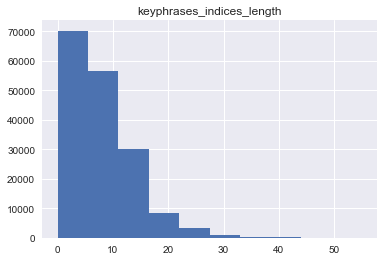

In [222]:
import matplotlib.pyplot as plt
%matplotlib inline

cur_df.hist(column='keyphrases_indices_length')

In [223]:
key_vector_index_list = [item for sublist in cur_df["keyVector"].values for item in sublist]
unique, counts = np.unique(key_vector_index_list, return_counts=True)
[(x, count) for count, x in sorted(zip(counts,keyphrases), key=lambda pair: pair[0], reverse=True)]

[('reasonable', 34286),
 ('market', 33617),
 ('tea', 30732),
 ('busy', 27643),
 ('chicken', 27581),
 ('chewy', 26607),
 ('fresh', 26395),
 ('bar', 20813),
 ('meat', 19427),
 ('egg', 18821),
 ('mall', 17421),
 ('lunch', 17355),
 ('dinner', 16701),
 ('clean', 16455),
 ('fried', 16255),
 ('tart', 16223),
 ('cheese', 15926),
 ('beef', 15538),
 ('soup', 15497),
 ('salad', 15224),
 ('fast', 14840),
 ('dessert', 14328),
 ('pork', 14114),
 ('quick', 13570),
 ('cake', 13509),
 ('noodle', 13371),
 ('traditional', 13134),
 ('fry', 12796),
 ('fish', 11916),
 ('wine', 11848),
 ('parking', 11558),
 ('coffee', 10900),
 ('bread', 10613),
 ('pop', 10572),
 ('bun', 10491),
 ('gelato', 9971),
 ('crispy', 9328),
 ('sandwich', 8943),
 ('beer', 8864),
 ('waffle', 8701),
 ('pork bone soup', 8592),
 ('pleasant', 8548),
 ('corn', 8482),
 ('burger', 8344),
 ('tuna', 8255),
 ('potato', 7986),
 ('pasta', 7821),
 ('ice cream', 7811),
 ('shrimp', 7784),
 ('chocolate', 7356),
 ('dumpling', 7301),
 ('sushi', 7129),
 

In [224]:
cur_df['UserIndex'] = cur_df[USER_ID].astype('category').cat.rename_categories(range(0, cur_df[USER_ID].nunique()))
cur_df['ItemIndex'] = cur_df[ITEM_ID].astype('category').cat.rename_categories(range(0, cur_df[ITEM_ID].nunique()))
cur_df['Binary'] = (cur_df[RATING] > 4)*1

df_user_name = cur_df[['UserIndex',USER_ID]]
df_item_name = cur_df[['ItemIndex',ITEM_ID]]

total_review = len(cur_df)

print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(cur_df['Binary'].tolist())))
print("Number of key Phrase: {0}".format(len(df_keyphrases)))
print("Number of reviews: {0}".format(total_review))

Number of User: 2473
Number of Item: 10282
Number of Positive Review: 40500
Number of key Phrase: 235
Number of reviews: 169961


In [210]:
print ('positive/all review ratio is around: ', round(36955/157038*100), "%")

positive/all review ratio is around:  24 %


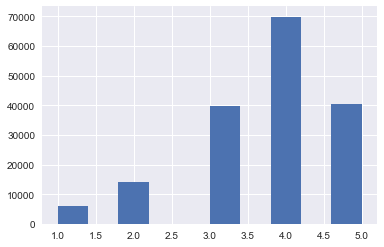

In [211]:
cur_df['rating'].hist()

# Save processed data

In [227]:
dataPath = '../../data/yelp/'

cur_df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')

In [199]:
cur_df = pd.read_csv('../../data/yelp/Data.csv', index_col=0,  encoding='latin-1')

# Data Sparsity

In [201]:
len(cur_df)

157038

In [203]:
cur_df.loc[15][REVIEW_TEXT]

"This place is located inside Pacific Mall and I believe it's the first store in Toronto (I haven't encountered one like this yet). Apparently, it's very popular around the world, with locations all shown on their poster. As a promotion, they have buy 1 get 1, until the end of today! So today is a great idea to try it. I tried the Oreo milk tea because they ran out of their lemon mango slush. I thought it wasn't that great. The milk tea and the Oreo didn't go too well. I also tried the lemon black tea which was a lot better, maybe this is why their name is called happy lemon, as its their specialty. For the service, it was friendly but the wait took a long time! Because of their promotion, they told us to return in 30 minutes to get our drinks and it looks like their computers were down and it was cash only.Perhaps I will give this place another try, although for a large lemon tea, it was a bit pricey at $6.50."

In [171]:
cur_df[BINARY_RATING] = (cur_df[RATING] >= 4)*1

In [204]:
len(cur_df[cur_df[BINARY_RATING] == 1])

36955

In [205]:
cur_df['UserIndex'].nunique()

2343

In [206]:
cur_df['ItemIndex'].nunique()

7456

In [208]:
36955/(2343*7456)

0.0021154122681203624

In [209]:
print("Number of Positive Review: {0}".format(sum(cur_df[BINARY_RATING].tolist())))

Number of Positive Review: 36955


In [210]:
coverage_ratio = 1-len(cur_df[cur_df['keyphrases_indices_length'] == 0])/len(cur_df)
print('The current keyphrase set covers {}% reviews'.format(coverage_ratio * 100))
print(cur_df['keyphrases_indices_length'].mean())

The current keyphrase set covers 99.10594887861537% reviews
9.92481437613826


In [211]:
print('A review can have at most {} keyphrases in the current keyphrase set'.format(cur_df['keyphrases_indices_length'].max()))

A review can have at most 59 keyphrases in the current keyphrase set


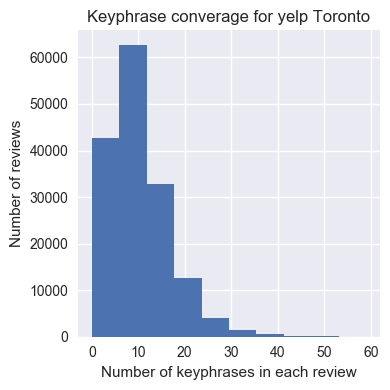

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure(figsize=(4, 4), dpi=100)
ax1 = fig1.add_subplot(111)

cur_df.hist(column='keyphrases_indices_length', ax=ax1)

ax1.set_title("Keyphrase converage for yelp Toronto")
plt.xlabel('Number of keyphrases in each review')
plt.ylabel('Number of reviews')

# legend = plt.legend(loc='upper right', shadow=True,prop={'size':10})
plt.tight_layout()

In [216]:
plt.savefig('../figs/keyphrase converage for yelp Toronto')